In [1]:
# Lorenz model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# model parameters (=> "chaotic" system)
s = 10.0
r = 28.0
b = 8.0/3.0

In [20]:
# time window, time step, ...
T = 5.0
N = 4000
dt = T/N

In [21]:
# observation frequency
freqobs = 100 # every 100 time steps, we have one observation


In [22]:
# solve direct model
def lorenz(X0): # X0 is a vector dimension 3
    X = np.zeros((N+1,3))
    X[0,:] = X0 # initialisation
    for i in range(N): # time loop
        X[i+1,0] = X[i,0] + dt * s*(X[i,1]-X[i,0]) # x component
        X[i+1,1] = X[i,1] + dt * (r*X[i,0]-X[i,1]-X[i,0]*X[i,2]) # y component
        X[i+1,2] = X[i,2] + dt * (X[i,0]*X[i,1]-b*X[i,2]) # z component
    return X


In [23]:
# direct simulation
X0test = np.array([-4.62,-6.61,17.94])
Xtest = lorenz(X0test)

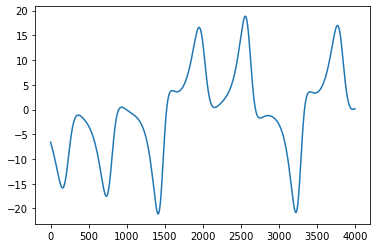

In [24]:
# plot solution
plt.plot(Xtest[:,1])

In [25]:
# twin experiments: we generate our observations from our model and a known initial condition
Xobs = lorenz(X0test)
# possibly add noise
noise = np.random.randn(N+1,3)
noiselevel = 1.0
###noiselevel = 0.0
Xobs = Xobs + noiselevel*noise
# from now, use Xobs at some particular (observation) times, and try to recover X0test
# assume we observe everything => H = Id
R = noiselevel*np.identity(3)
Rinv = np.linalg.inv(R)
###Rinv = np.identity(3)

In [26]:
# background solution:
Xb0 = np.array([-4.0,-6.0,18.0])
###Xb0 = X0test
Xb = lorenz(Xb0) # the trajectory we get without data assimilation
B = np.identity(3)
Binv = np.linalg.inv(B)

In [27]:
# cost function
def cost(X0): # J(X0)
    # background part
    J = 0.5*np.dot(X0-Xb0,Binv.dot(X0-Xb0))
    # observation part
    # solve direct model
    X = lorenz(X0)
    for i in range(0,N+1,freqobs):
        J = J + 0.5*np.dot(X[i,:]-Xobs[i,:],Rinv.dot(X[i,:]-Xobs[i,:]))
    return J

In [28]:
cost(X0test)

55.69508672704045

In [33]:
# resolution of adjoint model
def lorenzadj(X): # X is the full direct trajectory
    P = np.zeros((N+1,3))
    P[N,:] = 0.0 # initialisation with a final condition
    # in case of observations at the final time: add forcing term
    if np.mod(N,freqobs) == 0:
        P[N,:] = P[N,:] - Rinv.dot(X[N,:]-Xobs[N,:])
    for i in range(N,0,-1): # backwards time loop
        P[i-1,0] = P[i,0] + dt * (-s*P[i,0]+(r-X[i-1,2])*P[i,1]+X[i-1,1]*P[i,2]) # p component
        P[i-1,1] = P[i,1] + dt * (s*P[i,0]-P[i,1]+X[i-1,0]*P[i,2]) # q component
        P[i-1,2] = P[i,2] + dt * (-X[i-1,0]*P[i,1]-b*P[i,2]) # r component
        # in case of observations, add forcing term
        if np.mod(i-1,freqobs) == 0:
            P[i-1,:] = P[i-1,:] - Rinv.dot(X[i-1,:]-Xobs[i-1,:])
    return P


In [34]:
# gradient of the cost function
def costadj(X0): # gradJ(X0)
    # compute the direct solution
    X = lorenz(X0)
    # compute the adjoint solution
    P = lorenzadj(X)
    # gradient
    gradJ = Binv.dot(X0-Xb0)-P[0,:]
    return gradJ

In [35]:
cost(X0test)
costadj(X0test)

array([-378.79905324, -166.4157759 ,  743.92832669])

In [37]:
# check if the gradient is correct!!!
# estimate the 1st component of the gradient = dJ/dx
Y = np.array([1,0,0])
epsilon = 0.0000000001
print(cost(X0test),cost(X0test+epsilon*Y))
(cost(X0test+epsilon*Y)-cost(X0test))/epsilon

55.69508672704045 55.69508668919694


-378.43506106582936